In [22]:
%run get_SERCA_equilibrium.ipynb

In [23]:
import numpy as np
from scipy.integrate import *
import matplotlib.pyplot as plt
from math import *
from scipy.optimize import *

In [24]:
cai = 100.0e-9
cae = 250e-6

N_avo=6.0221409e23

# Volume Normalisations
vol_er = (3.9*0.1*0.1)
vol_cyt = (4.0*0.5*0.5-vol_er)
vol_tot = vol_cyt + vol_er
ntot = 1
ctot = ntot/vol_tot
fvol_cyt = vol_cyt/vol_tot
fvol_er = vol_er/vol_tot

In [40]:
# ODE model
def ode(v ,t):
    Ca, PMCA0, PMCA1, PMCA2,\
    cbH0M0, cbH0M1, cbH0M2, cbH1M0, cbH1M1, cbH1M2, cbH2M0, cbH2M1, cbH2M2,\
    fx1, fx1a, fx2, fy2, fy1a, fy1, cae = v 
    
    for key in k.keys():
        exec(key + " = "+str(k[key]))
    for key in k.keys():
        exec("print("+str(k[key])+")")

    dx1 = fx1*(-kx1_x1a*Ca-kx1_y1)+fx1a*kx1a_x1+fy1*ky1_x1
    dx1a = fx1a*(-kx1a_x2*Ca-kx1a_x1)+fx1*Ca*kx1_x1a+fx2*kx2_x1a
    dx2 = fx2*(-kx2_y2-kx2_x1a)+fx1a*Ca*kx1a_x2+fy2*ky2_x2

    dy1 = fy1*(-ky1_y1a*cae-ky1_x1)+fy1a*ky1a_y1+fx1*kx1_y1
    dy1a = fy1a*(-ky1a_y2*cae-ky1a_y1)+fy1*cae*ky1_y1a+fy2*ky2_y1a
    dy2 = fy2*(-ky2_x2-ky2_y1a)+fy1a*cae*ky1a_y2+fx2*kx2_y2

    dcae = -cae*(fy1a*ky1a_y2 + fy1*ky1_y1a) + (fy1a*ky1a_y1 + fy2*ky2_y1a)
    dCa = (Ca*(-fx1*kx1_x1a-fx1a*kx1a_x2)+fx2*kx2_x1a+fx1a*kx1a_x1)
    
    #er leaks
    dcae += kleak*(Ca - cae)
    dCa += -vol_er/vol_cyt*kleak*(Ca - cae)
    
    ### PMCA
    dCa   +=  (kPMCA0leak - kPMCA01*Ca)*PMCA0 + kPMCA10*PMCA1
    dPMCA0 = + kPMCA20*PMCA2 + kPMCA10*PMCA1 - kPMCA01*Ca*PMCA0
    dPMCA1 = - (kPMCA12 + kPMCA10)*PMCA1 + kPMCA01*Ca*PMCA0
    dPMCA2 = - kPMCA20*PMCA2 + kPMCA12*PMCA1

    ### Calcium Buffers
    dCa   +=     cbMoff*(cbH2M1 + cbH1M1 + cbH0M1 + 2*(cbH2M2 + cbH1M2 + cbH0M2)) \
            + cbHoff*(cbH2M1 + cbH1M1 + cbH0M1 + 2*(cbH2M2 + cbH2M1 + cbH2M0)) \
         - (+ cbMon*(cbH2M1 + cbH1M1 + cbH0M1  + 2*(cbH2M0 + cbH1M0 + cbH0M0)) \
            + cbHon*(cbH2M1 + cbH1M1 + cbH0M1  + 2*(cbH0M2 + cbH0M1 + cbH0M0)) )*Ca

    dcbH0M0 = - 2*(cbMon+cbHon)*cbH0M0*Ca + cbMoff*cbH0M1 + cbHoff*cbH1M0

    dcbH0M1 = + (2*cbMon*cbH0M0 - (cbMon + 2*cbHon)*cbH0M1)*Ca \
              + cbMoff*(2*cbH0M2 - cbH0M1) + cbHoff*cbH1M1

    dcbH0M2 = + cbMon*cbH0M1*Ca - 2*(cbMoff + cbHon*Ca)*cbH0M2 + cbHoff*cbH1M2

    dcbH1M0 = + (2*cbHon*cbH0M0 - (cbHon + 2*cbMon)*cbH1M0)*Ca\
              + cbMoff*cbH1M1   + cbHoff*(2*cbH2M0 - cbH1M0)

    dcbH1M1 = - ((cbMon + cbHon)*Ca + (cbHoff + cbMoff))*cbH1M1\
              + 2*((cbMoff*cbH1M2 + cbHoff*cbH2M1) + (cbMon*cbH1M0 + cbHon*cbH0M1)*Ca)

    dcbH1M2 = + (cbMon*cbH1M1 + 2*cbHon*cbH0M2 - cbHon*cbH1M2)*Ca\
              - (2*cbMoff + cbHoff)*cbH1M2 + 2*cbHoff*cbH2M2

    dcbH2M0 = + cbMoff*cbH2M1 + cbHon*cbH1M0*Ca - 2*(cbHoff + cbMon*Ca)*cbH2M0

    dcbH2M1 = + (cbHon*cbH1M1 - cbMon*cbH2M1 + 2*cbMon*cbH2M0)*Ca\
              + 2*(cbMoff*cbH2M2 - cbHoff*cbH2M1) - cbMoff*cbH2M1

    dcbH2M2 = + (cbMon*cbH2M1 + cbHon*cbH1M2)*Ca - 2*(cbHoff + cbMoff)*cbH2M2

    dX = [dCa, dPMCA0, dPMCA1, dPMCA2,\
          dcbH0M0, dcbH0M1, dcbH0M2, dcbH1M0, dcbH1M1, dcbH1M2, dcbH2M0, dcbH2M1, dcbH2M2,\
          dx1, dx1a, dx2, dy2, dy1a, dy1, dcae]
    
    return dX

In [41]:
# Reaction Rates
k_orig={
    'kx1_x1a' : 2*1.0e8,
    'kx1a_x2' : 1.0e8,
    'kx1a_x1' : 83.666,
    'kx2_x1a' : 2*83.666,
    'kx2_y2'  : 0.6,
    'ky2_x2'  : 4.118, #corrected
    'ky2_y1a' : 2*30.015,
    'ky1a_y1' : 30.015,
    'ky1a_y2' : 1.0e5,
    'ky1_y1a' : 2*1.0e5,
    'ky1_x1'  : 0.4,
    'kx1_y1'  : 1.20e-3,
    'kleak'     : 0,#40.45 #update

    'cbHon'   : 0.55e7,
    'cbHoff'  : 2.6,
    'cbMon'   : 4.35e7,
    'cbMoff'  : 35.8,
     
    'kPMCA01' : 1.5e8,
    'kPMCA10' : 20,
    'kPMCA12' : 100,
    'kPMCA20' : 1e5,
    'kPMCA0leak': 12.5

}

In [51]:
Ca=100e-9
cae=500e-6
pmca = np.array([2.39e-6, 5.82e-7, 4.54e-10])
npmca = 180
p = 180*pmca/sum(pmca)/N_avo/vol_cyt*1e15*1e6# uM
#print(p)

calbindin = [1.48e-05, 7.00e-06, 8.27e-07, 1.21e-05, 5.74e-06, 6.79e-07,\
2.49e-06, 1.18e-06, 1.39e-07] # Total conc. = 45e-6 uM

v0 = [Ca]+list(p)+calbindin+get_SERCA_equilibrium(cae*1e6)+[cae]
#print(len(v0))
#v0 = [0.79150804, 0.18920662, 0.011307258, 0.0023747239, 0.0039558979, 0.0016474684, cae]
#v0 = [1, 0, 0.0, 0, 0, 0.0, cae]




k=k_orig.copy()
sf=1
sm=1
for key in ['kx1_x1a','kx1a_x2']:
    k[key]=sf*k[key]
for key in ['kx2_y2','ky2_x2','kx1_y1','ky1_x1']:
    k[key]=sm*k[key]

k['kleak']=0#0.09519188799639043
print(k)

{'kx1_x1a': 200000000.0, 'kx1a_x2': 100000000.0, 'kx1a_x1': 83.666, 'kx2_x1a': 167.332, 'kx2_y2': 0.6, 'ky2_x2': 4.118, 'ky2_y1a': 60.03, 'ky1a_y1': 30.015, 'ky1a_y2': 100000.0, 'ky1_y1a': 200000.0, 'ky1_x1': 0.4, 'kx1_y1': 0.0012, 'kleak': 0, 'cbHon': 5500000.0, 'cbHoff': 2.6, 'cbMon': 43500000.0, 'cbMoff': 35.8, 'kPMCA01': 150000000.0, 'kPMCA10': 20, 'kPMCA12': 100, 'kPMCA20': 100000.0, 'kPMCA0leak': 12.5}


/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


In [52]:
tstep = 1e-4
tf = 100
t = np.linspace(0, tf, tf/tstep+1)

# Solve ODE
sol = odeint(ode, v0, t)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
10

200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0


20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6


200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
10

4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6


100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
20000

4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6


100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150

12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.0

43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100

100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.1

200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
10

200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
100000.0
200000.0
0.4
0.0012
0
5500000.0
2.6
43500000.0
35.8
150000000.0
20
100
100000.0
12.5
200000000.0
100000000.0
83.666
167.332
0.6
4.118
60.03
30.015
10

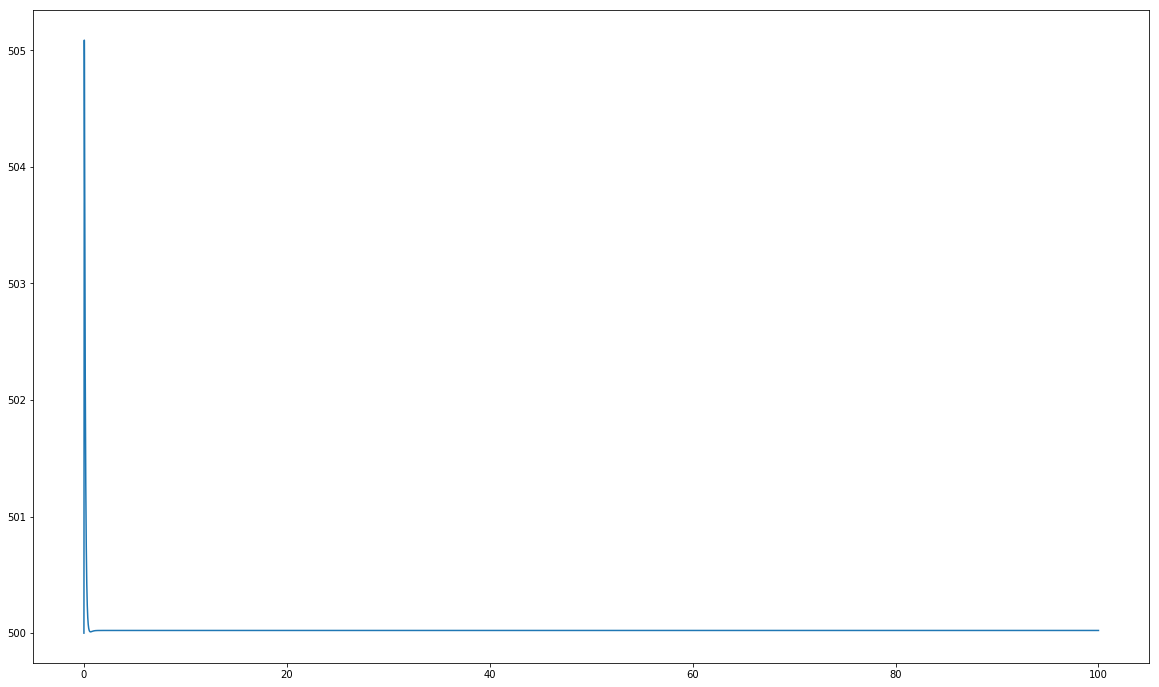

In [53]:
plt.figure(figsize=(20,12))
plt.plot(t,sol[:,-1]*1e6)
#plt.ylim((249.99e-6,250.03e-6))

In [87]:
kleak=255
ER_conc_rate=(2.1675*kleak+6.214988)*1e15/N_avo/vol_er*1e6

ER_conc_rate/250

0.09519188799639043